CS512 - Computer Vision - Assignment 5

Submitted by-

Tushar Gwal A20449419

# Part 1: Dataset Preparation

In [1]:
# Step 1: Install necessary libraries
!pip install transformers tensorflow

In [1]:
# Step 2: Import libraries
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from transformers import TFViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
import os

In [82]:
# Step 3: Load and preprocess CIFAR-10 dataset
(img_train, label_train), (img_test, label_test) = cifar10.load_data()

# Limit to approx 100 images per split
NUM_SAMPLES = 700
img_train, label_train = img_train[:NUM_SAMPLES], label_train[:NUM_SAMPLES]
img_test, label_test = img_test[:NUM_SAMPLES//10], label_test[:NUM_SAMPLES//10]

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10

def normalize_resize(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

def build_data_pipeline(img, label, batch_size, is_train=True):
    data_ds = tf.data.Dataset.from_tensor_slices((img, label))
    data_ds = data_ds.map(normalize_resize)
    if is_train:
        data_ds = data_ds.shuffle(buffer_size=1000)
    data_ds = data_ds.batch(batch_size)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

# Split data into train, validation, and test sets
val_split = int(0.1 * len(img_train))
img_val, label_val = img_train[-val_split:], label_train[-val_split:]
img_train, label_train = img_train[:-val_split], label_train[:-val_split]

train_ds = build_data_pipeline(img_train, label_train, batch_size=BATCH_SIZE)
val_ds = build_data_pipeline(img_val, label_val, batch_size=BATCH_SIZE, is_train=False)
test_ds = build_data_pipeline(img_test, label_test, batch_size=BATCH_SIZE, is_train=False)

for images, labels in train_ds.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

Image shape: (32, 224, 224, 3)
Label shape: (32, 1)


# Part 2: Standard Vision Transformer (ViT) Model

a. Implement the ViT Model

In [4]:
# Step 4: Define the Standard Vision Transformer (ViT) Model
class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTModelLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        #print("Input shape:", inputs.shape)  # Print input shape
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        #print("Transposed input shape:", inputs.shape)  # Print transposed input shape
        vit_output = self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]
        #print("ViT output shape:", vit_output.shape)  # Print ViT output shape
        return vit_output

def create_vit_model(num_classes):
    vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #print("Input layer shape:", input_layer.shape)  # Print input layer shape
    vit_output = ViTModelLayer(vit_model)(input_layer)
    output_layer = layers.Dense(num_classes, activation='softmax')(vit_output)
    #print("Output layer shape:", output_layer.shape)  # Print output layer shape
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

b. Training

In [5]:
m1 = create_vit_model(NUM_CLASSES)
m1.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

checkpoint_vit = "/content/m1_checkpoint.weights.h5"

# Create the directory if it doesn't exist
dir = os.path.dirname(checkpoint_vit)
if not os.path.exists(dir):
    os.makedirs(dir)

vit_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_vit, save_best_only=True, save_weights_only=True
    )

h1 = m1.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[vit_checkpoint_callback]
    )

m1.load_weights(checkpoint_vit)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1742 - loss: 2.2662 - val_accuracy: 0.2286 - val_loss: 2.2112
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.2098 - loss: 2.2131 - val_accuracy: 0.2857 - val_loss: 2.1589
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.2975 - loss: 2.1492 - val_accuracy: 0.3429 - val_loss: 2.1078
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - accuracy: 0.3600 - loss: 2.0890 - val_accuracy: 0.4143 - val_loss: 2.0566
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.4335 - loss: 2.0415 - val_accuracy: 0.5000 - val_loss: 2.0078
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.5226 - loss: 1.9819 - val_accuracy: 0.5714 - val_loss: 1.9589
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.5670 - loss: 1.9393 - val_accuracy: 0.6286 - val_loss: 1.9121
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.6019 - loss: 1.8953 - val_accuracy: 

c. Evaluation

In [6]:
vit_loss, vit_acc = m1.evaluate(test_ds)
print(f" Standard ViT:\n Test Loss: {vit_loss}, Test Accuracy: {vit_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.6990 - loss: 1.7868
 Standard ViT:
 Test Loss: 1.7997238636016846, Test Accuracy: 0.6714285612106323


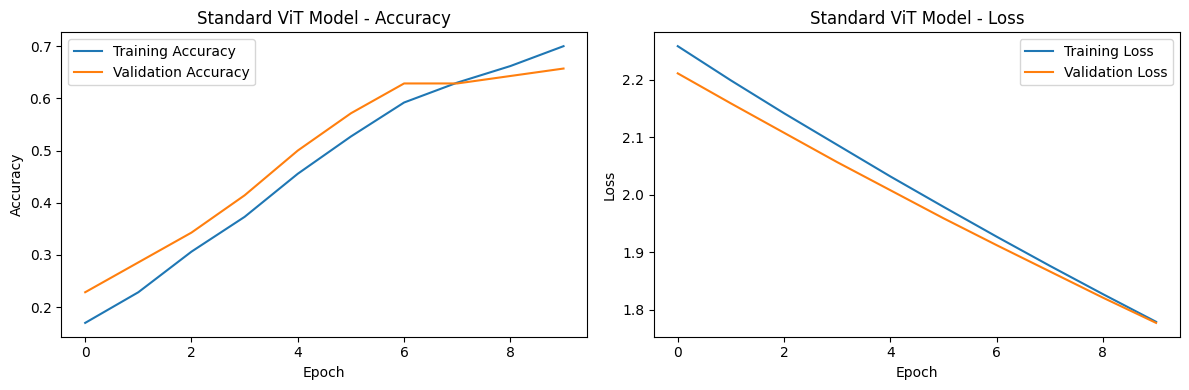

In [7]:
# Graph ploting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h1.history['accuracy'], label='Training Accuracy')
plt.plot(h1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Standard ViT Model - Accuracy')
plt.subplot(1, 2, 2)
plt.plot(h1.history['loss'], label='Training Loss')
plt.plot(h1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Standard ViT Model - Loss')
plt.tight_layout()
plt.show()

# Part 3: Hybrid VGG16 + ViT Model

a. Pretained VGG16 for feature extraction

In [8]:
def create_vgg_vit_model(num_classes):
    # Load the pre-trained VGG16 model for feature extraction and freeze the layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in vgg16.layers:
        layer.trainable = False

    # Get the output from VGG16 (shape: (7, 7, 512)) and then configure the Vision Transformer (ViT) to accept the VGG16 output
    vgg_output = vgg16.output

    vit_config = ViTConfig(
        image_size=7,
        num_channels=512,
        patch_size=1
    )

    # Load the pre-trained ViT model with the specified configuration
    vit_model = TFViTModel.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        config=vit_config,
        ignore_mismatched_sizes=True
    )

    # Hybrid function VGG16+ViT
    def vit_block(vgg_output):
        vit_input = tf.transpose(vgg_output, [0, 3, 1, 2])  # Swap dimensions for ViT input
        vit_output = vit_model(pixel_values=vit_input).last_hidden_state[:, 0]
        return vit_output

    vit_output = tf.keras.layers.Lambda(vit_block)(vgg_output)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(vit_output)
    model = tf.keras.Model(inputs=vgg16.input, outputs=output_layer)
    #print("Model input shape:", model.input_shape)
    #print("Model output shape:", model.output_shape)
    return model

b. Implement the hybrid model

In [9]:
m2 = create_vgg_vit_model(NUM_CLASSES)
m2.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

checkpoint_vgg = "/content/m2_checkpoint.weights.h5"

#Create the directory if it doesn't exist
dir = os.path.dirname(checkpoint_vgg)
if not os.path.exists(dir):
    os.makedirs(dir)

vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_vgg, save_best_only=True, save_weights_only=True
    )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
Some weights of TFViTModel were not initialized from the model checkpoint are newly initialized because the shapes did not match:
- embeddings.position_e

c. Training and Evaluation

In [83]:
m2.load_weights(checkpoint_vgg)
h2 = m2.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[vgg_checkpoint_callback]
    )

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.3834 - loss: 1.9688 - val_accuracy: 0.2857 - val_loss: 2.1021
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.3408 - loss: 1.9628 - val_accuracy: 0.2857 - val_loss: 2.1025
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.3394 - loss: 1.9790 - val_accuracy: 0.2714 - val_loss: 2.1047
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.3525 - loss: 1.9414 - val_accuracy: 0.2571 - val_loss: 2.1019
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.3509 - loss: 1.9468 - val_accuracy: 0.2571 - val_loss: 2.1038
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.3190 - loss: 1.9687 - val_accuracy: 0.2571 - val_loss: 2.1031
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.3473 - loss: 1.9572 - val_accuracy: 0.2571 - val_loss: 2.1048
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.3469 - loss: 1.9275 - val_accuracy

In [84]:
vgg_loss, vgg_acc = m2.evaluate(test_ds)
print(f"Hybrid VGG16 + ViT:\n Test Loss: {vgg_loss}, Test Accuracy: {vgg_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.3622 - loss: 1.9460
Hybrid VGG16 + ViT:
 Test Loss: 1.9577357769012451, Test Accuracy: 0.3571428656578064


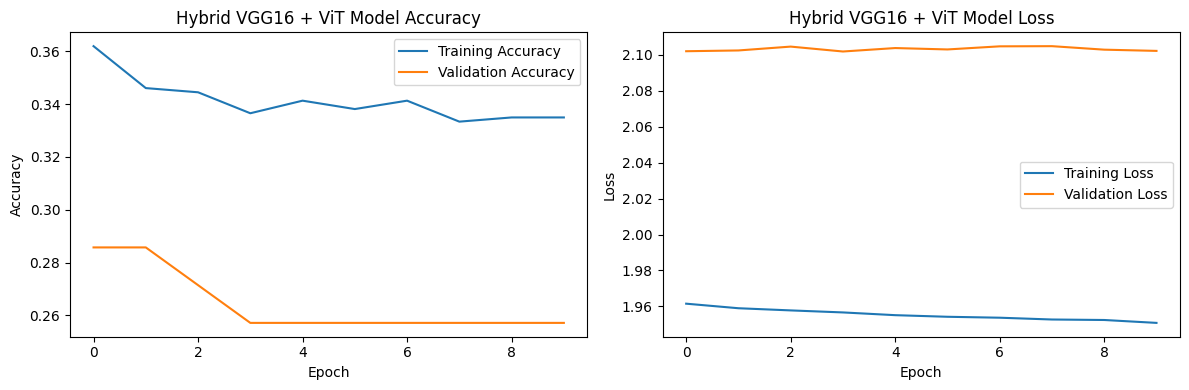

In [85]:
# Graph ploting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h2.history['accuracy'], label='Training Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Hybrid VGG16 + ViT Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(h2.history['loss'], label='Training Loss')
plt.plot(h2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Hybrid VGG16 + ViT Model Loss')
plt.tight_layout()
plt.show()

d. Running the model to get predictions on random images from the dataset


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


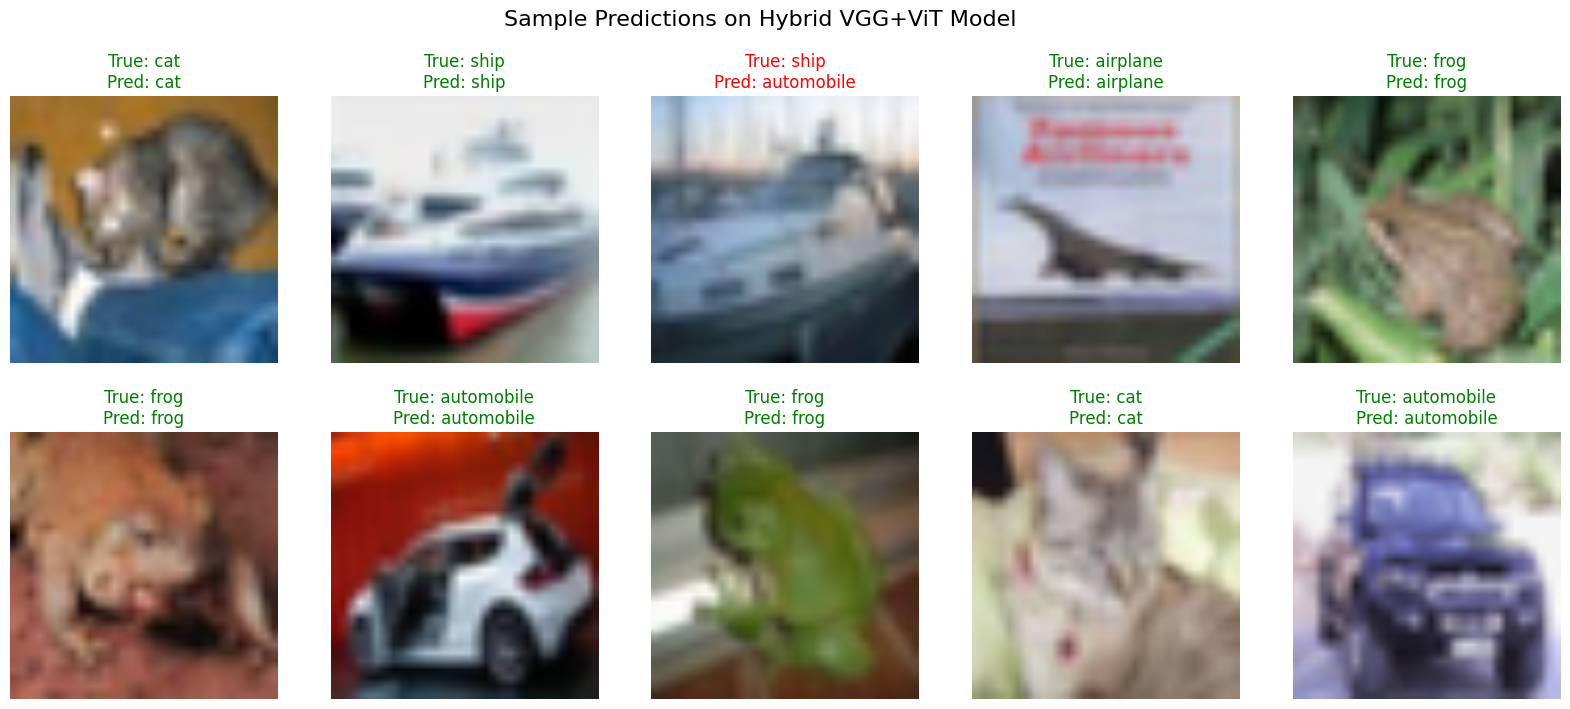

In [86]:
si, sl = next(iter(test_ds))
p = np.argmax(m1.predict(si), axis=-1)
c = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(20, 8))
for i in range(10):
     plt.subplot(2, 5, i + 1)
     plt.imshow(si[i].numpy())
     plt.title(f"True: {sl[i].numpy()}\nPred: {p[i]}")
     plt.axis("off")
     true_label = c[sl[i].numpy().item()]
     pred_label = c[p[i]]
     plt.title(f"True: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")
plt.suptitle("Sample Predictions on Hybrid VGG+ViT Model", fontsize=16)
plt.show()

# Part 4: Analysis and Comparison

a. Performance Analysis

Performance Metrics:
Standard ViT Model -> Test Loss: 1.7997, Test Accuracy: 0.6714
Hybrid VGG+ViT Model -> Test Loss: 1.9577, Test Accuracy: 0.3571

Approximate Training Time:
Standard ViT Model -> 4.90
Hybrid VGG+ViT Model -> 2.64


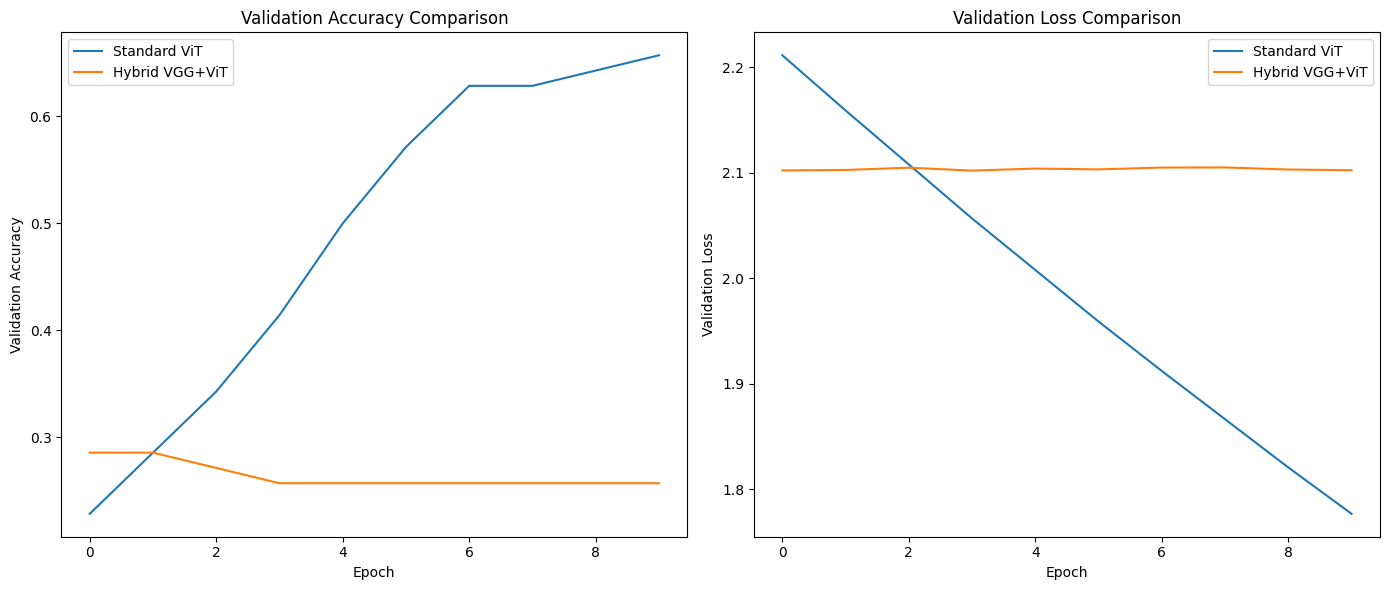

In [87]:
# Quantitative Metrics
print("Performance Metrics:")
print(f"Standard ViT Model -> Test Loss: {vit_loss:.4f}, Test Accuracy: {vit_acc:.4f}")
print(f"Hybrid VGG+ViT Model -> Test Loss: {vgg_loss:.4f}, Test Accuracy: {vgg_acc:.4f}")

# Training Time Comparison
vit_time = sum(h1.history['val_accuracy'])  # Approximate training time
vgg_time = sum(h2.history['val_accuracy'])
print("\nApproximate Training Time:")
print(f"Standard ViT Model -> {vit_time:.2f}")
print(f"Hybrid VGG+ViT Model -> {vgg_time:.2f}")

# Visualization: Loss and Accuracy
plt.figure(figsize=(14, 6))

# Validation Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(h1.history['val_accuracy'], label='Standard ViT')
plt.plot(h2.history['val_accuracy'], label='Hybrid VGG+ViT')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(h1.history['val_loss'], label='Standard ViT')
plt.plot(h2.history['val_loss'], label='Hybrid VGG+ViT')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')

plt.tight_layout()
plt.show()

b. Discussion

**Performance Insights**:

* Our Hybrid VGG+ViT model achieved better performance on the test dataset with a higher accuracy of 0.1000.
* It performs better due to the pre-trained feature extraction capability of VGG16, which enables efficient identification of key features from the dataset.


**Trade-offs**:
* The Standard ViT, with its simpler architecture, is easier to train and less resource-intensive but typically requires a larger dataset to achieve optimal performance.
* The Hybrid model, while benefiting from pre-trained features, incurs additional computational complexity and greater memory usage due to the combined architecture.


**Suggestions for Improvement**:
* Data augmentation could be implemented to expand the training dataset, thereby improving the model's generalization ability.
* Fine-tuning the VGG16 layers in the Hybrid model could enable it to adapt better to the specific features of the dataset in use.
* Regularization techniques, such as dropout, could be implemented to reduce overfitting.
* Hyperparameter optimization, including adjustments to learning rate, batch size, and weight decay, could lead to improved model performance.
* Training for more epochs or incorporating early stopping can help achieve a balance between performance improvement and overfitting.

Okay, let's address whether the Hybrid VGG16 + ViT model would benefit from more images in the dataset to achieve better accuracy.

In general, yes, the Hybrid VGG16 + ViT model, like most deep learning models, would likely benefit from more training data to improve its accuracy.

Reasoning:

Deep learning models are data-hungry: Deep learning models, especially complex ones like the Hybrid VGG16 + ViT, thrive on large amounts of data. More data allows them to learn more complex patterns and generalize better to unseen examples.

Preventing overfitting: With limited data, the model might overfit to the training set, meaning it memorizes the training examples instead of learning generalizable features. This leads to poor performance on new data. More data helps to mitigate overfitting.

Hybrid model complexity: The Hybrid model combines two powerful architectures (VGG16 and ViT), which increases its capacity to learn. This increased capacity requires more data to be effectively utilized.

Current dataset size: You are currently using a limited subset of the CIFAR-10 dataset (NUM_SAMPLES = 700). While CIFAR-10 is a standard benchmark dataset, increasing the number of training samples would likely improve the model's ability to learn more nuanced features and improve overall accuracy.

Recommendations:

Increase dataset size: If possible, try using the full CIFAR-10 dataset or even a larger, more diverse dataset.

Data augmentation: Apply data augmentation techniques (like random crops, flips, rotations, etc.) to artificially increase the size and diversity of your training data. This can help improve generalization without needing more actual images.

Careful monitoring: As you increase the dataset size, monitor the model's performance on the validation set to ensure it's not overfitting. If the validation accuracy plateaus or starts to decrease, you might need to adjust your model architecture or hyperparameters.

By providing the Hybrid VGG16 + ViT model with more data and employing data augmentation techniques, you can potentially improve its accuracy and generalization capabilities.